In [1]:
import main
import plot_inequality as plot_ineq
import time
import importlib
import io_manager
import numpy as np
importlib.reload(plot_ineq)
#run stuff here
start_time = time.perf_counter()
print("Running main")

# ***** may want to change how trans is generated its redundant in do file.
of_name = None
main_path = "C:/Users/Ben/My Drive/PhD/PhD Year 3/3rd Year Paper/Model/My Code/MH_Model/my_code/model_uncert/"
trans_path = main_path + "input/50p_age_moms/MH_trans_by_MH_clust_age.csv"

do_phi_H_calib = False
myPars, myShocks, sols, sims = main.main_io(main_path, out_folder_name = of_name, 
                                            H_trans_path = trans_path, do_phi_H_calib=do_phi_H_calib, output_flag = False)


Running main
*****Running main_io with default out_folder_name*****
Using health transition matrix from: C:/Users/Ben/My Drive/PhD/PhD Year 3/3rd Year Paper/Model/My Code/MH_Model/my_code/model_uncert/input/50p_age_moms/MH_trans_by_MH_clust_age.csv
Solver ran in 7.3036915999998655 seconds
Calibrating with alpha_lab_targ = 0.33496439, w0_mean_targ = 2.1986477, w0_sd_targ = 0.29952401, 
                                        w1_targ = 0.2915204, w2_targ = 0.27134400000000003, wH_targ = 0.051474661, phi_H_target = 0.02408891
***** Calibration iteration 0 *****
***** Calibration iteration 1 *****
***** Calibration iteration 2 *****
***** Calibration iteration 3 *****
***** Calibration iteration 4 *****
***** Calibration iteration 5 *****
***** Calibration iteration 6 *****
***** Calibration iteration 7 *****
***** Calibration iteration 8 *****
***** Calibration iteration 9 *****
***** Calibration iteration 10 *****
***** Calibration iteration 11 *****
***** Calibration iteration 12 *****


In [2]:
import numpy as np
import pandas as pd

H_hist = myShocks.H_hist

# Assuming H_hist has shape (4, 2, 1000, 52) from previous context
# Flatten to 2D array (8000, 52)
reshaped_H_hist = H_hist.reshape(-1, H_hist.shape[-1])
print("reshaped_H_hist.shape", reshaped_H_hist.shape)

# Create an empty array with proper shape (8000 * 52 rows, 3 columns)
stata_form_arr = np.ones((reshaped_H_hist.shape[0] * reshaped_H_hist.shape[1], 3))
print("stata_form_arr.shape", stata_form_arr.shape)

# Populate the stata_form_arr correctly by iterating over rows and columns
row_counter = 0
for r in range(reshaped_H_hist.shape[0]):  # Loop over individuals
    for c in range(reshaped_H_hist.shape[1]):  # Loop over age (time steps)
        stata_form_arr[row_counter, 0] = r  # Individual ID
        stata_form_arr[row_counter, 1] = c  # Age (time step)
        stata_form_arr[row_counter, 2] = reshaped_H_hist[r, c]  # MH value
        row_counter += 1

# Convert to pandas DataFrame
stata_df = pd.DataFrame(stata_form_arr, columns=["individual", "age", "MH"])
# print(stata_df.head(10))
print("stata_df.shape", stata_df.shape)

# Calculate mean MH by age using pandas groupby
pd_mean_MH_by_age = stata_df.groupby("age").MH.mean()
# print("pd_mean_MH_by_age", pd_mean_MH_by_age)

# Calculate mean MH by age using numpy directly
np_mean_by_age = np.mean(reshaped_H_hist, axis=0)
# print("np_mean_by_age", np_mean_by_age)

# export pandas DataFrame to csv
export_path = main_path + "output/sim_MH_stata_format.csv"
stata_df.to_csv(export_path, index=False)


reshaped_H_hist.shape (20000, 52)
stata_form_arr.shape (1040000, 3)
stata_df.shape (1040000, 3)


In [3]:
import my_toolbox as tb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

input_path = main_path + "input/50p_age_moms/"
# autocorr_input_path = main_path + "autocorr_matrix.csv"
autocorr_input_path = main_path + "autocorr_matrix_indiv_lag.csv"

# read in csv to pandas
autocorr_pd = pd.read_csv(input_path + "autocorr_matrix.csv")
# print(autocorr_pd.head())


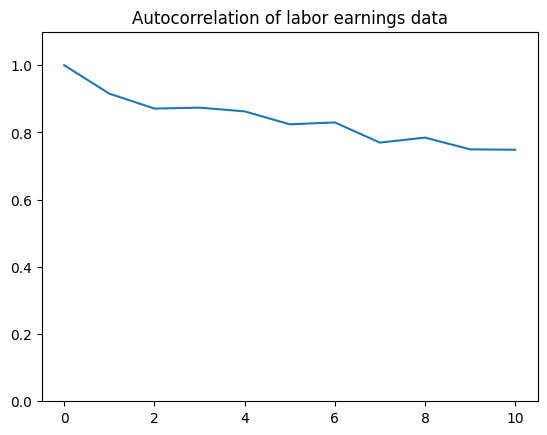

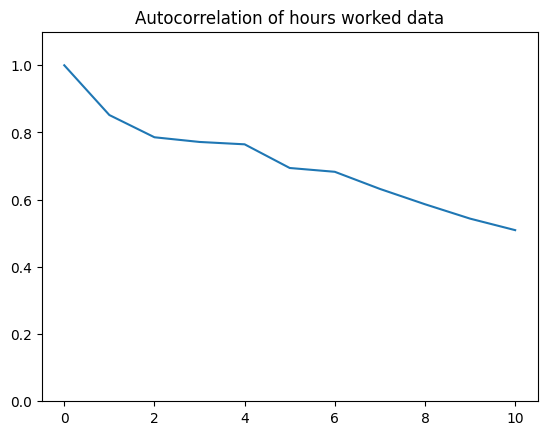

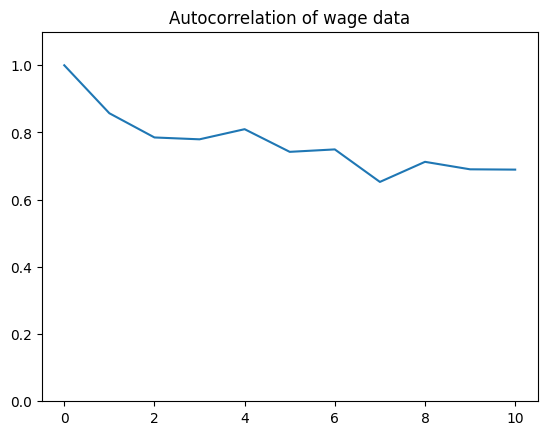

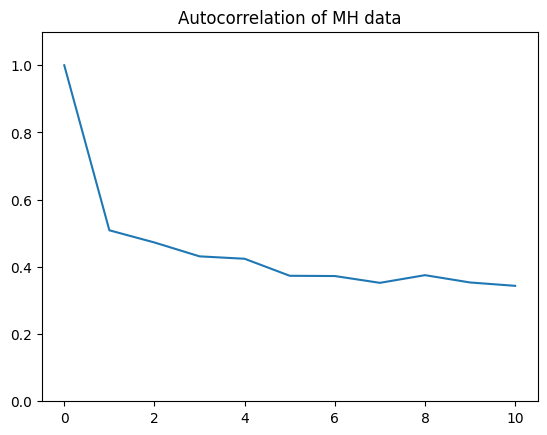

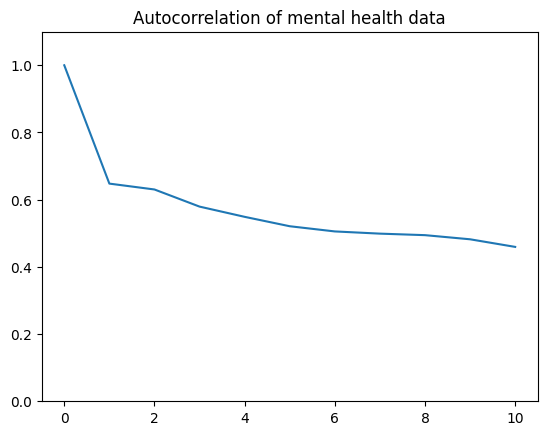

In [4]:
autocorr_y_lim = [0, 1.1]
from typing import Tuple

def plot_autocorr(autocorr_data: np.ndarray, var_name: str = None, y_lim: list = [0, 1.1], quietly: bool = False)-> Tuple[plt.Figure, plt.Axes]:
    fig_data, ax_data = plt.subplots()
    ax_data.plot(autocorr_data)
    ax_data.set_title(f"Autocorrelation of {var_name}")
    ax_data.set_ylim(y_lim)
    if not quietly:
        plt.show()
    return fig_data, ax_data

quietly = True

lab_earn_autocorr = autocorr_pd["labor_earnings"].values
fig_data_earn, ax_data_earn = plot_autocorr(lab_earn_autocorr, "labor earnings data", autocorr_y_lim, quietly = quietly)
hours_autocorr = autocorr_pd["job_hours"].values
fig_data_hours, ax_data_hours = plot_autocorr(hours_autocorr, "hours worked data", autocorr_y_lim, quietly = quietly)
wage_autocorr = autocorr_pd["wage"].values
fig_data_wage, ax_data_wage = plot_autocorr(wage_autocorr, "wage data", autocorr_y_lim)
MH_autocorr = autocorr_pd["MH"].values
fig_data_MH, ax_data_MH = plot_autocorr(MH_autocorr, "MH data", autocorr_y_lim, quietly = quietly)
mental_health_autocorr = autocorr_pd["mental_health"].values
fig_data_menal_health, ax_data_mental_health = plot_autocorr(mental_health_autocorr, "mental health data", 
                                                             autocorr_y_lim, quietly = quietly)

In [5]:

def lagged_corr(data: np.ndarray, max_lag=10):
    """
    Calculate Pearson correlation coefficient for each lag (0 to max_lag) 
    for a flattened 2D array (individuals, time).
    
    Parameters:
    data (np.array): Input data with shape (4, 2, 1000, 52).
    max_lag (int): Maximum lag to calculate correlations for. Default is 10.
    
    Returns:
    np.array: Correlation coefficients for lags from 0 to max_lag.
    """
    # Step 1: Flatten the data to (8000, 52)
    flattened_data = data.reshape(-1, data.shape[-1])  # Shape (8000, 52)

    # Step 2: Initialize an array to store correlation coefficients
    correlations = np.zeros(max_lag + 1)

    # Step 3: Loop through each lag (from 0 to max_lag)
    for lag in range(max_lag + 1):
        if lag > 0:
            # Create lagged version of the data by shifting along the time dimension
            lagged_data = np.roll(flattened_data, shift=-lag, axis=-1)

            # Truncate both original and lagged data to avoid comparing rolled values
            original_truncated = flattened_data[:, :-lag]
            lagged_truncated = lagged_data[:, :-lag]

            #Flatten both to single row
            original_truncated = original_truncated.flatten()
            lagged_truncated = lagged_truncated.flatten()

            # Calculate Pearson correlation across all individuals for this lag
            corr_matrix = np.corrcoef(original_truncated, lagged_truncated)
            # print(f"corr_matrix for lag {lag}", corr_matrix)
            correlations[lag] = corr_matrix[0, 1]  # Get the correlation coefficient
        else:
            #Flatten data to single row
            row_data = flattened_data.flatten()
            # Calculate correlation for lag 0 directly
            correlations[lag] = np.corrcoef(row_data)

    return correlations


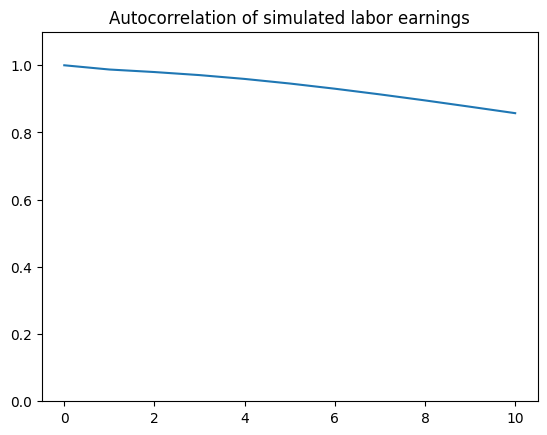

sim_lab_earn_ac [1.         0.98739612 0.97985457 0.97075512 0.95937195 0.94574838
 0.93026043 0.91337817 0.89546044 0.87661956 0.8574639 ]


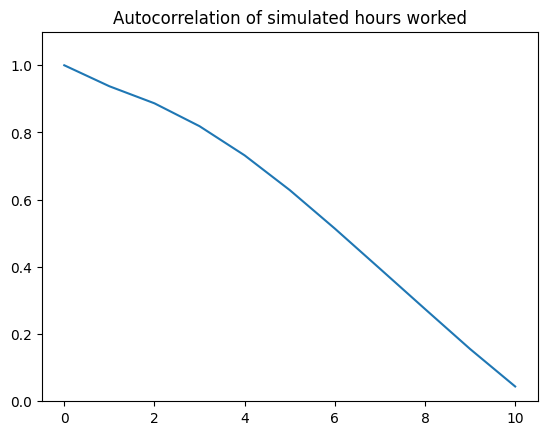

sim_hours_ac [1.         0.93759545 0.88678356 0.81868766 0.73189186 0.62862644
 0.51403632 0.39462827 0.27463259 0.15559133 0.04404527]


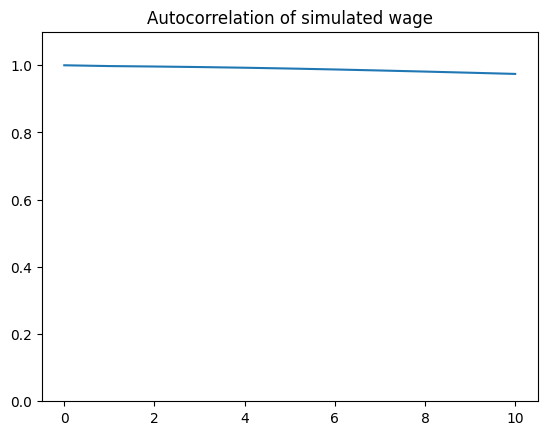

sim_wage_ac [1.         0.99764998 0.99630718 0.99471015 0.99270836 0.99029755
 0.98753742 0.98450468 0.98125952 0.97782155 0.9742982 ]


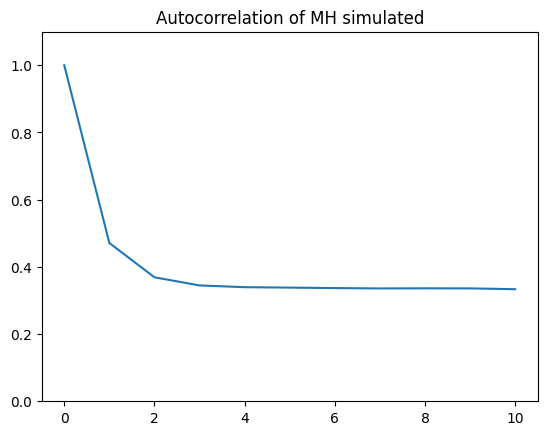

H_hist_ac [1.         0.47108236 0.36899684 0.34478718 0.33956876 0.33827875
 0.3368899  0.33582031 0.3362077  0.33597182 0.33360003]


In [6]:
sim_lab_earn = sims["lab_earnings"][:, :, :, :-1]
sim_lab_earn_ac = lagged_corr(sim_lab_earn, max_lag=10)
fig_sim_earn, ax_sim_earn = plot_autocorr(sim_lab_earn_ac, "simulated labor earnings", autocorr_y_lim)
print("sim_lab_earn_ac", sim_lab_earn_ac)

sim_hours = sims["lab"][:, :, :, :-1]
sim_hours_ac = lagged_corr(sim_hours, max_lag=10)
fig_sim_hours, ax_sim_hours = plot_autocorr(sim_hours_ac, "simulated hours worked", autocorr_y_lim)
print("sim_hours_ac", sim_hours_ac)

sim_wage = sims["wage"][:, :, :, :-1]
sim_wage_ac = lagged_corr(sim_wage, max_lag=10)
fig_sim_wage, ax_sim_wage = plot_autocorr(sim_wage_ac, "simulated wage", autocorr_y_lim)
print("sim_wage_ac", sim_wage_ac)
# mean_wage_by_age = np.mean(sim_wage, axis=tuple(range(sim_wage.ndim - 1))) 
# print("mean_wage_by_age", mean_wage_by_age)

H_hist = myShocks.H_hist[:, :, :, :-1]
H_hist_ac = lagged_corr(H_hist, max_lag=10)
fig_sim_H_ac, ax_sim_H_ac = plot_autocorr(H_hist_ac, "MH simulated", autocorr_y_lim)
print("H_hist_ac", H_hist_ac)


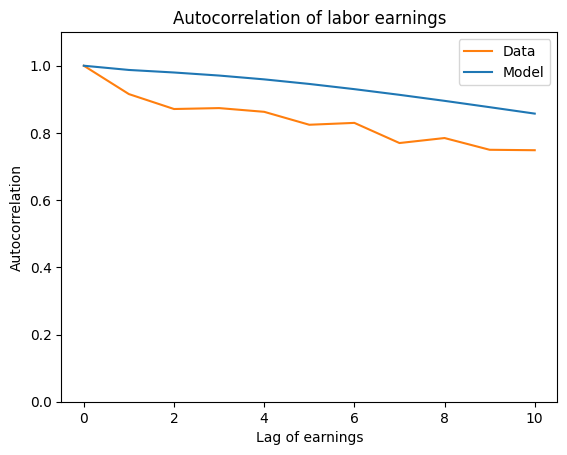

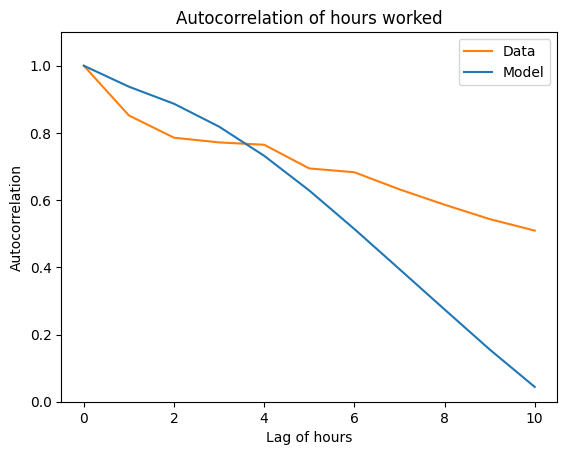

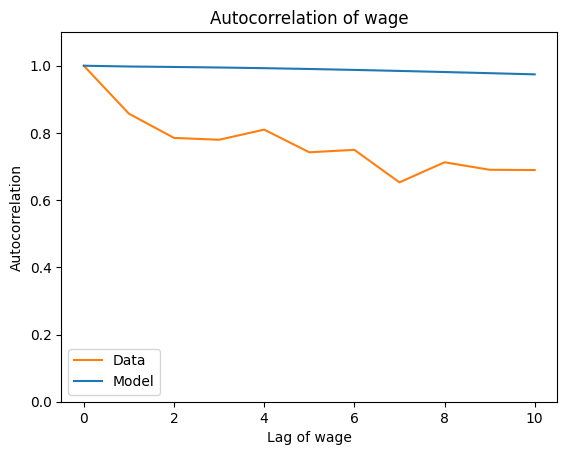

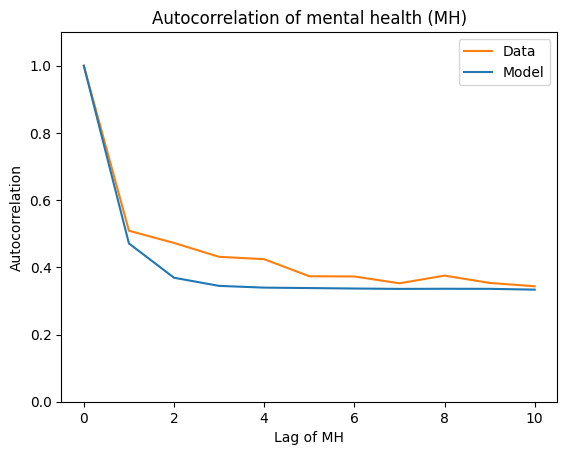

In [7]:
importlib.reload(tb)

corr_save_path = main_path + "output/autocorr_figs/"

comb_fig_title_prefix = "Autocorrelation of "
# comb_fig_title_suffix = " in the data and the model"
comb_fig_title_suffix = ""

label_lists = [["Data"], ["Model"]]
color_list = ["C1", "C0"]
x_label = "Lag"
y_label = "Autocorrelation"


fig_comb_earn_autocorr, ax_comb_earn_autocorr = tb.combine_plots([(fig_data_earn, ax_data_earn), (fig_sim_earn, ax_sim_earn)], 
                                                                 comb_fig_title = comb_fig_title_prefix + "labor earnings" + comb_fig_title_suffix, 
                                                                 x_label = x_label + " of earnings", y_label = y_label,
                                                                 label_lists = label_lists, colors= color_list, save_path = corr_save_path + "autocorr_lab_earnings.pdf")

fig_comb_hours_autocorr, ax_comb_hours_autocorr = tb.combine_plots([(fig_data_hours, ax_data_hours), (fig_sim_hours, ax_sim_hours)],
                                                                     comb_fig_title = comb_fig_title_prefix + "hours worked" + comb_fig_title_suffix, 
                                                                     x_label = x_label + " of hours", y_label = y_label,
                                                                     label_lists = label_lists, colors= color_list, save_path = corr_save_path + "autocorr_hours_worked.pdf")

fig_comb_wage_autocorr, ax_comb_wage_autocorr = tb.combine_plots([(fig_data_wage, ax_data_wage), (fig_sim_wage, ax_sim_wage)],
                                                                    comb_fig_title = comb_fig_title_prefix + "wage" + comb_fig_title_suffix, 
                                                                    x_label = x_label + " of wage", y_label = y_label,
                                                                    label_lists = label_lists, colors= color_list, save_path = corr_save_path + "autocorr_wage.pdf")

fig_comb_MH_autocorr, ax_comb_MH_autocorr = tb.combine_plots([(fig_data_MH, ax_data_MH), (fig_sim_H_ac, ax_sim_H_ac)],
                                                                comb_fig_title = comb_fig_title_prefix + "mental health (MH)" + comb_fig_title_suffix, 
                                                                x_label = x_label + " of MH", y_label = y_label,
                                                                label_lists = label_lists, colors= color_list, save_path = corr_save_path + "autocorr_MH.pdf")

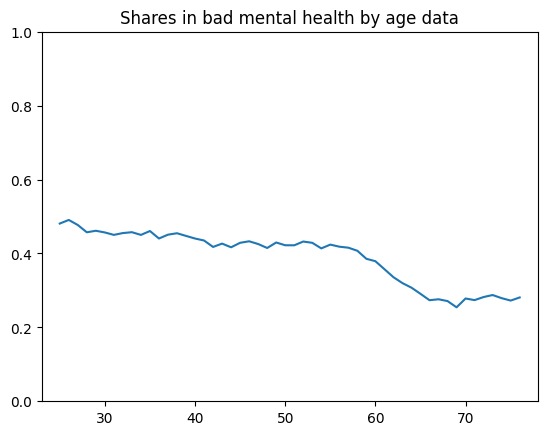

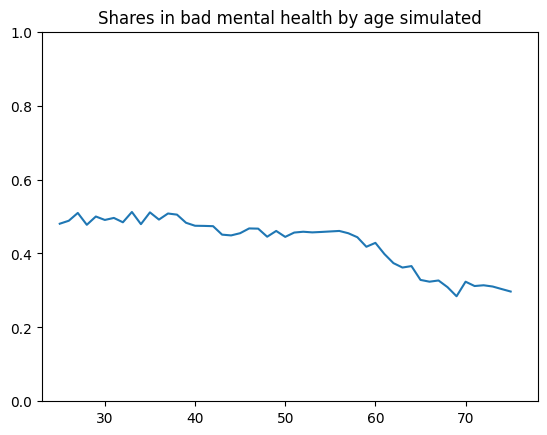

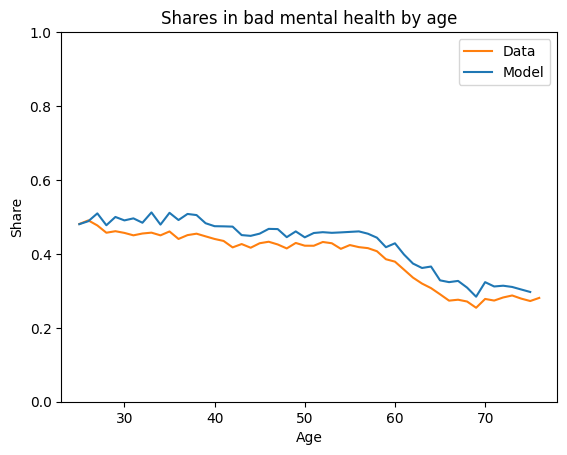

In [8]:
import model_uncert as model

# trans_path_uncond = main_path + "input/50p_age_moms/MH_trans_uncond_age.csv"
# myPars.H_trans = io_manager.read_and_shape_H_trans_uncond_age(myPars, trans_path_uncond)

# H_hist = myShocks.H_hist[:, :, :, :-1]
# H_hist_ac = lagged_corr(H_hist, max_lag=10)
# fig_sim_H_ac, ax_sim_H_ac = plot_autocorr(H_hist_ac, "MH simulated", autocorr_y_lim)
# # print("H_hist_ac", H_hist_ac)

shares_y_lim = [0, 1.0]
# shares in bad health by earnings (maybe later by wage, hours, etc)
age_grid = myPars.age_grid
bad_MH_age_data = pd.read_csv(input_path + "mean_bad_MH_by_age.csv")
# get second column as numpy array
bad_MH_age_data = bad_MH_age_data.to_numpy()[:,1:]
# plot shares in bad health by earnings
fig_bad_MH_data, ax_bad_MH_data = plt.subplots()
ax_bad_MH_data.plot(age_grid, bad_MH_age_data)
ax_bad_MH_data.set_title("Shares in bad mental health by age data")
ax_bad_MH_data.set_xlim([age_grid[0]-2, age_grid[-1]+2])    
ax_bad_MH_data.set_ylim(shares_y_lim)
plt.show()

# model shares in bad health by age
weighted_H_hist = model.gen_weighted_sim(myPars, H_hist) 
good_MH_age_sim = np.sum(weighted_H_hist, tuple(range(H_hist.ndim - 1)))
bad_MH_age_sim = 1 - good_MH_age_sim
# print("good_MH_age_sim", good_MH_age_sim)
# print("bad_MH_age_sim", bad_MH_age_sim)
fig_bad_MH_sim, ax_bad_MH_sim = plt.subplots()
ax_bad_MH_sim.plot(age_grid[:-1], bad_MH_age_sim)
ax_bad_MH_sim.set_title("Shares in bad mental health by age simulated")
ax_bad_MH_sim.set_xlim([age_grid[0]-2, age_grid[-1]+2])
ax_bad_MH_sim.set_ylim(shares_y_lim)
plt.show()

fig_comb_bad_MH, ax_comb_bad_MH = tb.combine_plots([(fig_bad_MH_data, ax_bad_MH_data), (fig_bad_MH_sim, ax_bad_MH_sim)],
                                                    comb_fig_title = "Shares in bad mental health by age", x_label = "Age", y_label = "Share", 
                                                    label_lists = label_lists, colors= color_list, save_path = corr_save_path + "shares_bad_MH.pdf")

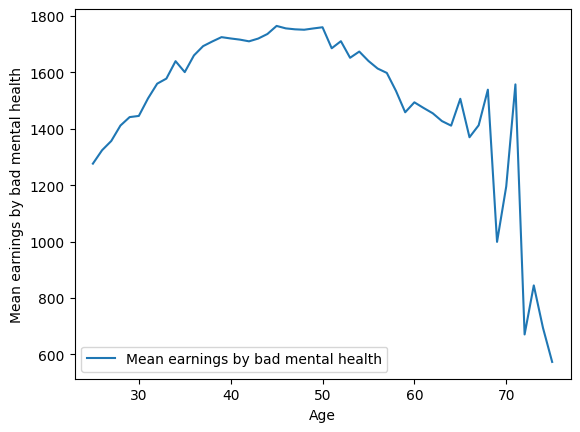

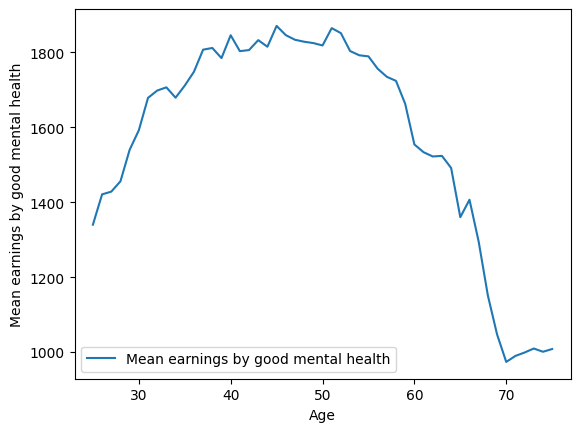

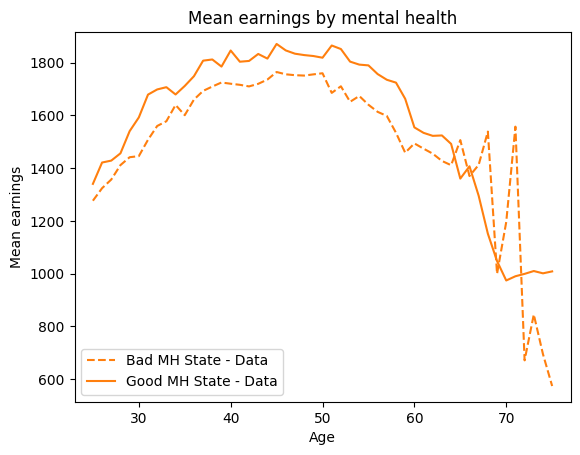

In [9]:
#  Mean earnings by health types/states
# -states first? model and data.
importlib.reload(tb)
shares_y_lim = [0, 1.0]
label_lists = [["Bad MH State - Data"], ["Good MH State - Data"]]
color_list = ["C1"]
linestyles = ["--", "-"]
age_grid = myPars.age_grid
earnings_data_pd : pd.DataFrame = pd.read_csv(input_path + "mean_earnings_by_health_age.csv") 
# drop last column
earnings_data_pd = earnings_data_pd.iloc[:, :-1]
# rename columns
earnings_data_pd.columns = ["age", "bad_MH", "good_MH"]
earnings_bad_MH_data = earnings_data_pd["bad_MH"].values
earnings_good_MH_data = earnings_data_pd["good_MH"].values
# plot
fig_earn_bad_MH_data, ax_earn_bad_MH_data = tb.plot_lc_mom_by_age(earnings_bad_MH_data, age_grid, "Mean earnings by bad mental health") 
fig_earn_good_MH_data, ax_earn_good_MH_data = tb.plot_lc_mom_by_age(earnings_good_MH_data, age_grid, "Mean earnings by good mental health")
                                                                        
# combine 
fig_comb_earns_by_MH_data, ax_comb_earns_by_MH_data = tb.combine_plots([(fig_earn_bad_MH_data, ax_earn_bad_MH_data), (fig_earn_good_MH_data, ax_earn_good_MH_data)],
                                                                comb_fig_title = "Mean earnings by mental health", x_label = "Age", y_label = "Mean earnings",
                                                                label_lists = label_lists, colors= color_list, linestyles = linestyles,
                                                                save_path = corr_save_path + "mean_earnings_by_MH.pdf")

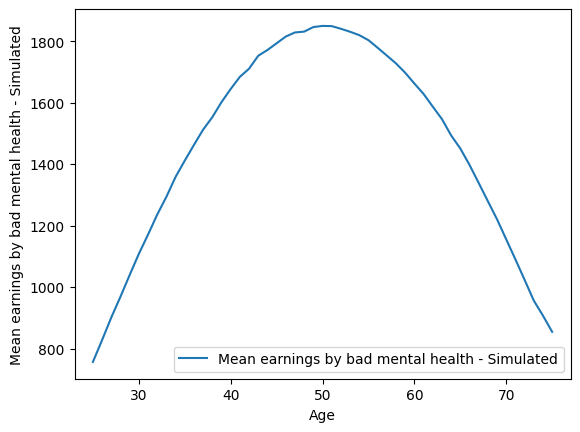

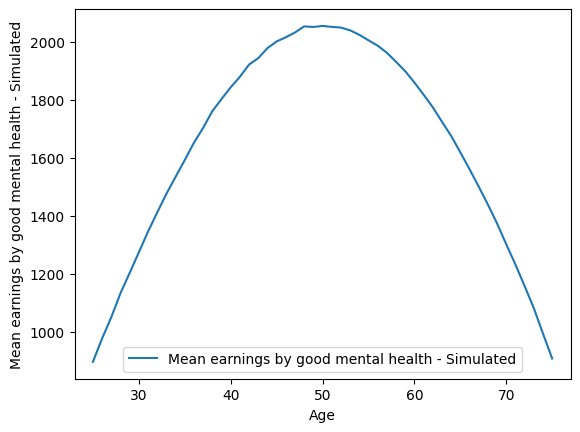

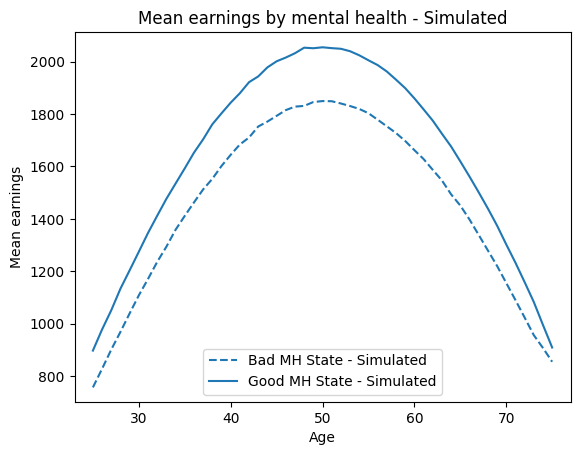

In [10]:
# model
H_hist: np.ndarray = myShocks.H_hist[:, :, :, :myPars.J]
lab_earnings_trim = sims["lab_earnings"][:, :, :, :myPars.J]

good_earnings = lab_earnings_trim * (H_hist == 1) 
bad_earnings = lab_earnings_trim * (H_hist == 0)

# Apply weights to the good_earnings matrix
good_earnings_weighted = good_earnings * myPars.lab_fe_weights[:, np.newaxis, np.newaxis, np.newaxis]
good_earnings_weighted *= myPars.H_type_perm_weights[np.newaxis, :, np.newaxis, np.newaxis]
# Mask zero values with NaN so they are ignored
good_earnings_masked = np.where(good_earnings_weighted != 0, good_earnings_weighted, np.nan)
# Compute the sum of valid weighted earnings (ignoring NaN) along all axes except the last one
sum_good_earnings = np.nansum(good_earnings_masked, axis=tuple(range(good_earnings.ndim - 1)))
# Create a mask of non-zero entries in good_earnings_weighted
non_zero_mask = (good_earnings_weighted != 0)
# Apply the same weights to the mask to get the total weight sum where the earnings were non-zero
total_weights = np.sum(non_zero_mask * myPars.lab_fe_weights[:, np.newaxis, np.newaxis, np.newaxis] * myPars.H_type_perm_weights[np.newaxis, :, np.newaxis, np.newaxis],
                        axis=tuple(range(good_earnings.ndim - 1)))
# Calculate the mean where non-zero entries exist
mean_good_earnings_by_age = np.divide(sum_good_earnings, total_weights, where=total_weights != 0)

# Apply weights to the bad_earnings matrix
bad_earnings_weighted = bad_earnings * myPars.lab_fe_weights[:, np.newaxis, np.newaxis, np.newaxis]
bad_earnings_weighted *= myPars.H_type_perm_weights[np.newaxis, :, np.newaxis, np.newaxis]
# Mask zero values with NaN so they are ignored
bad_earnings_masked = np.where(bad_earnings_weighted != 0, bad_earnings_weighted, np.nan)
# Compute the sum of valid weighted earnings (ignoring NaN) along all axes except the last one
sum_bad_earnings = np.nansum(bad_earnings_masked, axis=tuple(range(bad_earnings.ndim - 1)))
# Create a mask of non-zero entries in bad_earnings_weighted
non_zero_mask = (bad_earnings_weighted != 0)
# Apply the same weights to the mask to get the total weight sum where the earnings were non-zero
total_weights = np.sum(non_zero_mask * myPars.lab_fe_weights[:, np.newaxis, np.newaxis, np.newaxis] *
                       myPars.H_type_perm_weights[np.newaxis, :, np.newaxis, np.newaxis], axis=tuple(range(bad_earnings.ndim - 1)))
# Calculate the mean where non-zero entries exist
mean_bad_earnings_by_age = np.divide(sum_bad_earnings, total_weights, where=total_weights != 0)

# plot
shares_y_lim = [0, 1.0]
label_lists = [["Bad MH State - Simulated"], ["Good MH State - Simulated"]]
color_list = ["C0"]
linestyles = ["--", "-"]
age_grid = myPars.age_grid

fig_earn_bad_MH_sim, ax_earn_bad_MH_sim = tb.plot_lc_mom_by_age(mean_bad_earnings_by_age, age_grid, "Mean earnings by bad mental health - Simulated")
fig_earn_good_MH_sim, ax_earn_good_MH_sim = tb.plot_lc_mom_by_age(mean_good_earnings_by_age, age_grid, "Mean earnings by good mental health - Simulated")

# combine
fig_comb_earns_by_MH_sim, ax_comb_earns_by_MH_sim = tb.combine_plots([(fig_earn_bad_MH_sim, ax_earn_bad_MH_sim), (fig_earn_good_MH_sim, ax_earn_good_MH_sim)],
                                                                comb_fig_title = "Mean earnings by mental health - Simulated", x_label = "Age", y_label = "Mean earnings",
                                                                label_lists = label_lists, colors= color_list, linestyles = linestyles,
                                                                save_path = corr_save_path + "mean_earnings_by_MH_sim.pdf")

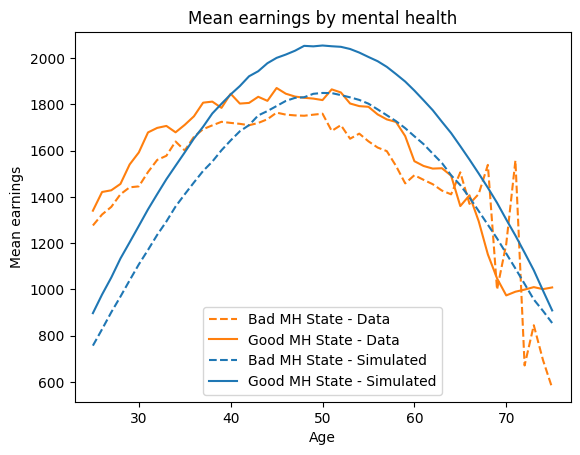

In [11]:
# combine the sim and data plots
fig_comb_earns_by_MH, ax_comb_earns_by_MH = tb.combine_plots([(fig_earn_bad_MH_data, ax_earn_bad_MH_data), (fig_earn_good_MH_data, ax_earn_good_MH_data),
                                                             (fig_earn_bad_MH_sim, ax_earn_bad_MH_sim), (fig_earn_good_MH_sim, ax_earn_good_MH_sim)],
                                                             comb_fig_title = "Mean earnings by mental health", x_label = "Age", y_label = "Mean earnings",
                                                             label_lists = [["Bad MH State - Data"], ["Good MH State - Data"], ["Bad MH State - Simulated"], ["Good MH State - Simulated"]],
                                                             colors= ["C1", "C1", "C0", "C0"], linestyles = ["--", "-", "--", "-"],
                                                             save_path = corr_save_path + "mean_earnings_by_MH_comb.pdf")

   age  job_hours_decimal  sd_job_hours_decimal  log_hours  sd_log_hours
0   25           0.348163              0.084273   3.509728      0.310806
1   26           0.348506              0.083051   3.512645      0.301833
2   27           0.347802              0.084371   3.510198      0.302492
3   28           0.345858              0.085272   3.503480      0.306344
4   29           0.343718              0.089316   3.493511      0.319117
   age       wage   sd_wage  log_wage  sd_log_wage
0   25   9.454164  3.201360  2.198648     0.299524
1   26   9.919938  4.359142  2.237288     0.315336
2   27   9.984156  3.593740  2.247989     0.316129
3   28  10.323462  3.838024  2.279717     0.318832
4   29  10.796422  4.384004  2.315664     0.342613


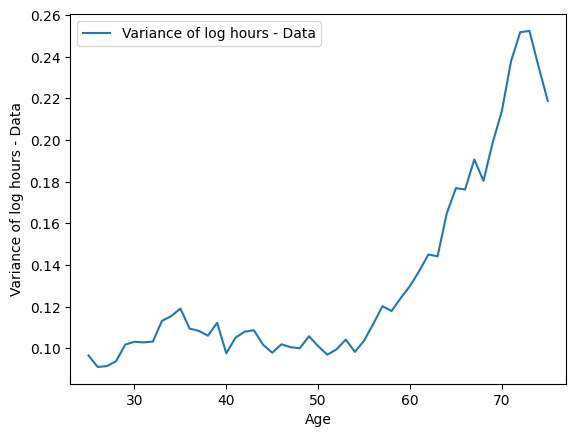

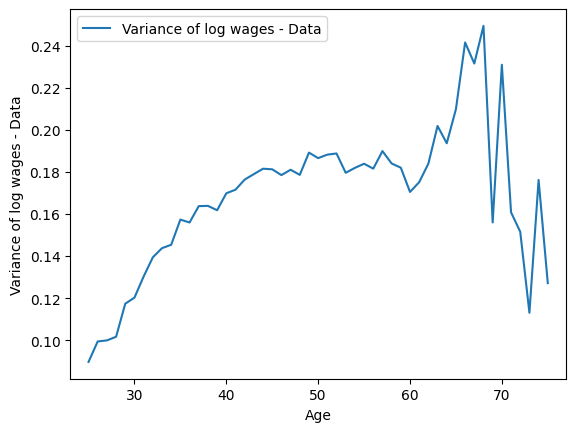

In [12]:
# Variance of log hours and log wages in the data
hours_data = pd.read_csv(input_path +  "labor_moments.csv")
print(hours_data.head())
wages_data = pd.read_csv(input_path + "wage_moments.csv")
print(wages_data.head())

hours_var_data = hours_data["sd_log_hours"].values**2
wages_var_data = wages_data["sd_log_wage"].values**2

# plot
fig_hours_var_data, ax_hours_var_data = tb.plot_lc_mom_by_age(hours_var_data, age_grid, "Variance of log hours - Data")
fig_wages_var_data, ax_wages_var_data = tb.plot_lc_mom_by_age(wages_var_data, age_grid, "Variance of log wages - Data")


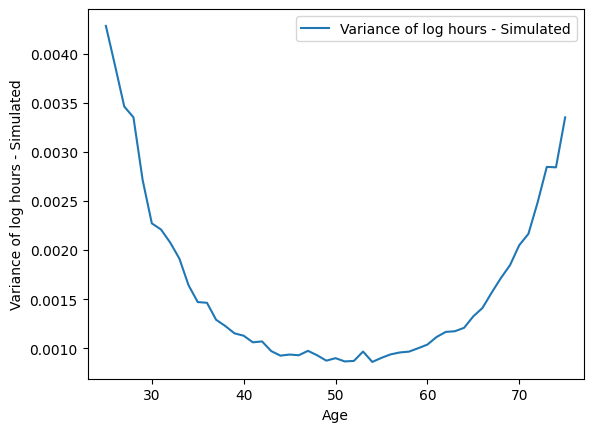

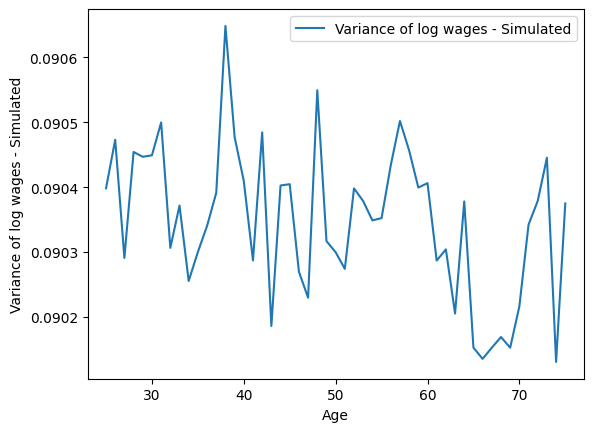

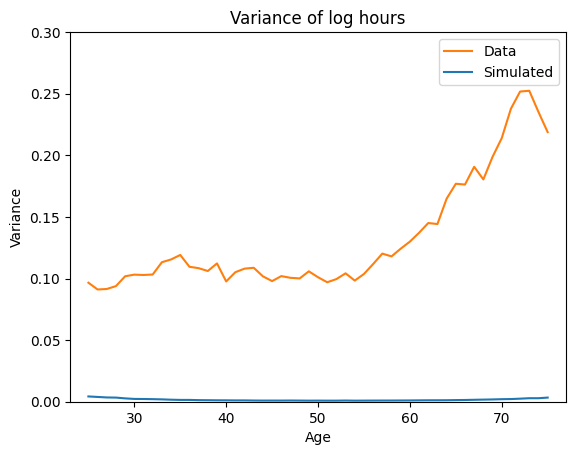

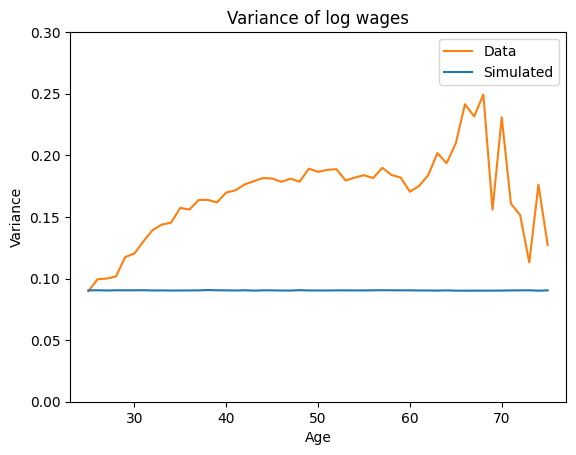

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Variance of log wages'}, xlabel='Age', ylabel='Variance'>)

In [13]:
# log sim hours where greater than 0
importlib.reload(plot_ineq)
sim_hours = sims["lab"][:, :, :, :myPars.J]*100

save_path = corr_save_path + "var_log_hours_sim.pdf"
fig_var_log_hours_sim, ax_var_log_hours_sim = plot_ineq.plot_var_log_sim(myPars, sim_hours, "Variance of log hours - Simulated", outpath = save_path, full_age_grid = True)

sim_wages = model.gen_wage_hist(myPars, myShocks)
save_path = corr_save_path + "var_log_wages_sim.pdf"
fig_var_log_wages_sim, ax_var_log_wages_sim = plot_ineq.plot_var_log_sim(myPars, sim_wages, "Variance of log wages - Simulated", outpath = save_path, full_age_grid = True)

# H_hist = myShocks.H_hist[:, :, :, :myPars.J]
# fig_var_MH_sim, ax_var_MH_sim = plot_ineq.plot_var_log_sim(myPars, H_hist, "Variance of MH - Simulated", full_age_grid = True)

# make two combination plots
y_lim = [0, 0.3]
tb.combine_plots([(fig_hours_var_data, ax_hours_var_data), (fig_var_log_hours_sim, ax_var_log_hours_sim)], y_lim = y_lim,
                    comb_fig_title = "Variance of log hours", x_label = "Age", y_label = "Variance", label_lists = [["Data"], ["Simulated"]],
                    colors = ["C1", "C0"], save_path = corr_save_path + "var_log_hours.pdf")

tb.combine_plots([(fig_wages_var_data, ax_wages_var_data), (fig_var_log_wages_sim, ax_var_log_wages_sim)], y_lim = y_lim,
                    comb_fig_title = "Variance of log wages", x_label = "Age", y_label = "Variance", label_lists = [["Data"], ["Simulated"]],
                    colors = ["C1", "C0"], save_path = corr_save_path + "var_log_wages.pdf")



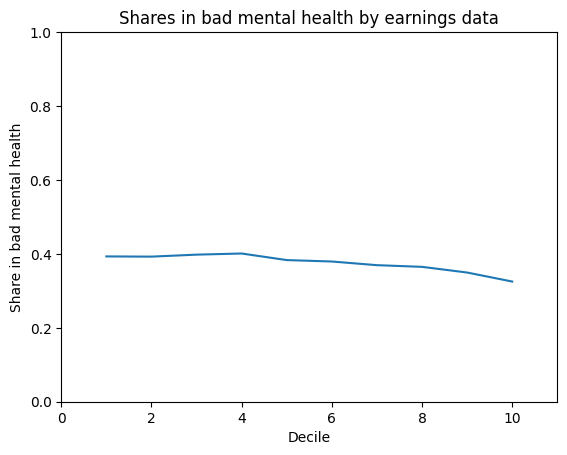

In [14]:
bad_MH_earn_data = pd.read_csv(input_path + "mean_bad_MH_by_earnings.csv")
decile_x_grid = np.arange(1, 11)
# get second column as numpy array
bad_MH_earn_data = bad_MH_earn_data.to_numpy()[:,1:]
# plot shares in bad health by earnings
fig_bad_MH_earn_data, ax_bad_MH_earn_data = plt.subplots()
ax_bad_MH_earn_data.plot(decile_x_grid, bad_MH_earn_data)
ax_bad_MH_earn_data.set_title("Shares in bad mental health by earnings data")
ax_bad_MH_earn_data.set_xlim([decile_x_grid[0]-1, decile_x_grid[-1]+1])
ax_bad_MH_earn_data.set_ylim(shares_y_lim)
ax_bad_MH_earn_data.set_xlabel("Decile")
ax_bad_MH_earn_data.set_ylabel("Share in bad mental health")
plt.show()

Earnings deciles: [ 148.79826514  439.22562329  803.86481964 1139.78742906 1445.13201556
 1761.86390714 2098.00697188 2468.56304254 2919.69387294 3498.34911649
 4695.5813377 ]
Share of individuals in good health by earnings decile: [0.55652285 0.56229105 0.62797173 0.60551781 0.56994118 0.57293137
 0.61003645 0.62389164 0.63238596 0.72641889]
Share of individuals in bad health by earnings decile: [0.44347715 0.43770895 0.37202827 0.39448219 0.43005882 0.42706863
 0.38996355 0.37610836 0.36761404 0.27358111]


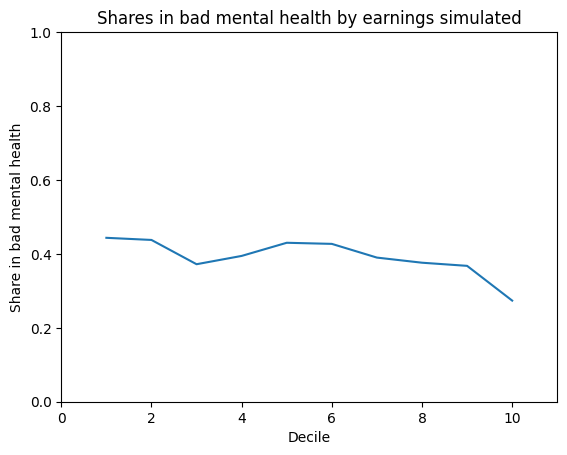

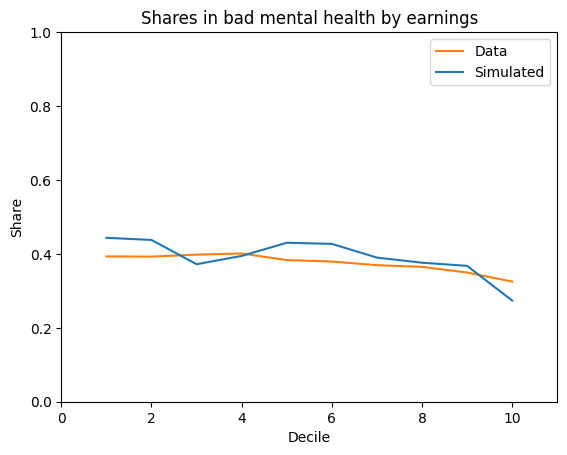

In [15]:
import numpy as np

# Step 1: Extract health and earnings histories
H_hist = myShocks.H_hist[:, :, :, :myPars.J]
earnings_sim = sims["lab_earnings"][:, :, :, :myPars.J]

# Step 2: Calculate earnings deciles
earnings_deciles = np.percentile(earnings_sim, np.arange(0, 101, 10))
print("Earnings deciles:", earnings_deciles)

# Step 3: Initialize array to store shares of people in good health (H_hist == 1) by decile
good_MH_by_earn_sim = np.zeros(10)

# Step 4: Loop over deciles to compute the share in good health
for i in range(10):
    if i == 0:
        # First decile: earnings <= first decile threshold
        earnings_mask = (earnings_sim <= earnings_deciles[i + 1])
    else:
        # Subsequent deciles: earnings between decile[i] and decile[i+1]
        earnings_mask = (earnings_sim > earnings_deciles[i]) & (earnings_sim <= earnings_deciles[i + 1])
    
    # Apply the mask to both H_hist and earnings_sim
    good_health_in_decile = H_hist[earnings_mask]
    
    # Calculate the share of individuals in good health for this decile
    good_MH_by_earn_sim[i] = np.mean(good_health_in_decile)

bad_MH_by_earn_sim = 1 - good_MH_by_earn_sim    
# Step 5: Print the results
print("Share of individuals in good health by earnings decile:", good_MH_by_earn_sim)
print("Share of individuals in bad health by earnings decile:", bad_MH_by_earn_sim)

# plot
fig_bad_MH_earn_sim, ax_bad_MH_earn_sim = plt.subplots()
ax_bad_MH_earn_sim.plot(decile_x_grid, bad_MH_by_earn_sim)
ax_bad_MH_earn_sim.set_title("Shares in bad mental health by earnings simulated")
ax_bad_MH_earn_sim.set_xlim([decile_x_grid[0]-1, decile_x_grid[-1]+1])
ax_bad_MH_earn_sim.set_ylim(shares_y_lim)
ax_bad_MH_earn_sim.set_xlabel("Decile")
ax_bad_MH_earn_sim.set_ylabel("Share in bad mental health")
plt.show()

color_list = ["C1", "C0"]
label_lists = [["Data"], ["Simulated"]]
# combine
fig_comb_bad_MH_earn, ax_comb_bad_MH_earn = tb.combine_plots([(fig_bad_MH_earn_data, ax_bad_MH_earn_data), (fig_bad_MH_earn_sim, ax_bad_MH_earn_sim)],
                                                    comb_fig_title = "Shares in bad mental health by earnings", x_label = "Decile", y_label = "Share", 
                                                    label_lists = label_lists, colors= color_list, 
                                                    save_path = corr_save_path + "shares_bad_MH_earn.pdf")